In [1]:
# 所有的头

In [139]:
import torch # for save
import os
from van import Fan
from localconfig import config
import datetime
import random
from pprint import pprint
import html
from pyltp import SentenceSplitter
from pyltp import Postagger
from pyltp import Segmentor
from pyltp import NamedEntityRecognizer
import matplotlib.pyplot as plt
from tqdm import tqdm
from IPython.display import Image
from IPython.core.display import HTML 
import pyecharts
from pyecharts import Pie
%matplotlib inline

plt.rcParams['font.sans-serif']=['FangSong'] #用来正常显示中文标签
plt.rcParams['axes.unicode_minus']=False #用来正常显示负号


In [3]:
# 所有的配置

In [12]:
keyword = '计算机系' # 关注的关键词
until_year = 2000 # 最早的年份
until_num = 500 # 截止的饭否数量
timeout = (60,60) # 超时时间

In [7]:
# 登录
fan = Fan(config['Consumer key'], config['Consumer secret'])
fan.xauth(config['my username'], config['my password'])

{'oauth_token': '1405515-071ad3666b5af9441d5cbb0dc1d3985b',
 'oauth_token_secret': '43cc293f5d127423f960b8636688577b'}

In [9]:
# 本小时内可用API次数
fan.request('GET', 'account/rate_limit_status', {}, timeout=timeout)

{'reset_time': 'Mon Mar 18 04:22:07 +0000 2019',
 'remaining_hits': 150,
 'hourly_limit': 150,
 'reset_time_in_seconds': 1552882927}

In [16]:
# 采集关键词消息
def datetimefromstr(s):
    return datetime.datetime.strptime(s, '%a %b %d %H:%M:%S %z %Y')
def get_status(keyword, until_year, until_num):
    latest = fan.request('GET', 'search/public_timeline', {'q':keyword, 'count':60}, timeout=timeout)
    while True:
        year = datetimefromstr(latest[-1]['created_at']).year
        if len(latest) >= until_num:
            break
        if year < until_year:
            break
        print(len(latest), year,'/', until_num, until_year)
        latest += fan.request('GET', 'search/public_timeline', { 'q':keyword, 'count':60, 'max_id':latest[-1]['id']}, timeout=timeout)[1:]
    return latest

In [17]:
# 下载并暂存
statuses = get_status(keyword, until_year, until_num)

60 2018 / 500 2000
119 2017 / 500 2000
178 2015 / 500 2000
237 2014 / 500 2000
296 2013 / 500 2000
355 2013 / 500 2000
414 2013 / 500 2000
473 2012 / 500 2000


TypeError: file must have a 'write' attribute

In [18]:
torch.save(statuses,'tmp_statuses.torch.pkl')

In [19]:
# 恢复
# statuses = torch.load('tmp_statuses.torch.pkl')

In [20]:
print(len(statuses))

532


In [21]:
# 从消息关系本身入手

In [22]:
# 时间段分布

In [35]:
print(datetimefromstr(statuses[-1]['created_at']))
print(datetimefromstr(statuses[0]['created_at']))
begin_year = datetimefromstr(statuses[-1]['created_at']).year
end_year = datetimefromstr(statuses[0]['created_at']).year

2012-09-12 01:06:01+00:00
2019-03-12 04:53:56+00:00


(array([ 98., 153.,  73.,  52.,  33.,  57.,  66.]),
 array([2012., 2013., 2014., 2015., 2016., 2017., 2018., 2019.]),
 <a list of 7 Patch objects>)

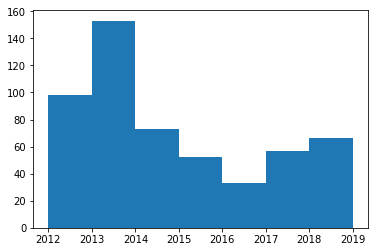

In [37]:
plt.hist([datetimefromstr(x['created_at']).year for x in statuses], bins = end_year-begin_year )

In [44]:
# 用户信息文件
os.path.exists('./users.torch.pkl')

True

In [50]:
# 预处理用户信息
userid_to_info = {}
if os.path.exists('./users.torch.pkl'):
    userid_to_info = torch.load('users.torch.pkl')
for x in statuses:
    userid_to_info[x['user']['id']] = x['user']
torch.save(userid_to_info, 'users.torch.pkl')
print(len(userid_to_info))

345


In [51]:
# 发表人数/总消息数量
uni_num = len(set([x['user']['id'] for x in statuses ]))
print(uni_num, len(statuses), uni_num/len(statuses))

345 532 0.6484962406015038


In [111]:
def get_top(l, num=5, reverse=False): # 从大到小
    cnt = {}
    for x in l:
        if x not in cnt:
            cnt[x] = 0
        cnt[x] += 1
    cnt_list = [(k,cnt[k],cnt[k]/len(l)) for k in cnt]
    cnt_list = sorted(cnt_list, key=lambda x:x[1])[::-1]
    if reverse:
        cnt_list = cnt_list[::-1]
    if num == -1:
        return cnt_list
    return cnt_list[:num]

In [145]:
def huabing(y): # x [(label,,0.xxx)]
    attr = [x[0] for x in y]
    v1 = [x[2] for x in y]
    if sum(v1) < 1.0:
        attr.append('其他')
        v1.append(1.0 - sum(v1))
    pie = Pie('')
    pie.add('', attr, v1, is_label_show=True)
    pie.render()
    return pie

In [158]:
# 发表top10的人
users_top = get_top([x['user']['id'] for x in statuses], num=20)
pprint(users_top)
huabing(users_top)

[('linuxeden', 13, 0.02443609022556391),
 ('moonlightblog', 13, 0.02443609022556391),
 ('qiub', 9, 0.016917293233082706),
 ('cashmoney', 8, 0.015037593984962405),
 ('dictionary', 7, 0.013157894736842105),
 ('elence', 6, 0.011278195488721804),
 ('~TZBuXHEv5KE', 6, 0.011278195488721804),
 ('传说中的芋头', 6, 0.011278195488721804),
 ('itdigest', 5, 0.009398496240601503),
 ('www21usbcom', 5, 0.009398496240601503),
 ('techshaoqun', 5, 0.009398496240601503),
 ('boryi', 5, 0.009398496240601503),
 ('superisaac', 5, 0.009398496240601503),
 ('Breadlin', 5, 0.009398496240601503),
 ('wukailun', 5, 0.009398496240601503),
 ('solibot', 5, 0.009398496240601503),
 ('涵虚', 4, 0.007518796992481203),
 ('edgarwang', 4, 0.007518796992481203),
 ('sakamotosan', 4, 0.007518796992481203),
 ('cankun920619', 4, 0.007518796992481203)]


In [159]:
def show_user_info(x):
    user = userid_to_info[x]
    pprint(user)

In [161]:
show_user_info(users_top[0][0])

{'birthday': '1977-01-01',
 'created_at': 'Thu May 14 10:41:10 +0000 2009',
 'description': 'Linuxeden开源社区',
 'favourites_count': 0,
 'followers_count': 120,
 'following': False,
 'friends_count': 1,
 'gender': '男',
 'id': 'linuxeden',
 'location': '北京 东城区',
 'name': 'linuxeden开源社',
 'notifications': False,
 'photo_count': 16486,
 'profile_background_color': '#acdae5',
 'profile_background_image_url': 'http://static.fanfou.com/img/bg/0.png',
 'profile_background_tile': False,
 'profile_image_url': 'http://s3.meituan.net/v1/mss_3d027b52ec5a4d589e68050845611e68/avatar/s0/00/e2/6d.jpg?1323998914',
 'profile_image_url_large': 'http://s3.meituan.net/v1/mss_3d027b52ec5a4d589e68050845611e68/avatar/l0/00/e2/6d.jpg?1323998914',
 'profile_link_color': '#0066cc',
 'profile_sidebar_border_color': '#b2d1a3',
 'profile_sidebar_fill_color': '#e2f2da',
 'profile_text_color': '#222222',
 'protected': False,
 'screen_name': 'linuxeden开源社',
 'statuses_count': 27439,
 'unique_id': '~fKCZ_CyWZkg',
 'url': 

In [162]:
# 引用top10的消息
in_reply_to_top = get_top([x['in_reply_to_status_id'] for x in statuses], num=10)
pprint(in_reply_to_top)

[('', 507, 0.9530075187969925),
 ('BQdL7XUegok', 1, 0.0018796992481203006),
 ('ryQ5-Gp6XoQ', 1, 0.0018796992481203006),
 ('tvbm636xwZE', 1, 0.0018796992481203006),
 ('XXO5gZXmRuw', 1, 0.0018796992481203006),
 ('RE7m1KaAKkg', 1, 0.0018796992481203006),
 ('5QJWO5Nac-I', 1, 0.0018796992481203006),
 ('BY2CVPWdPQc', 1, 0.0018796992481203006),
 ('Kmr_xPjKeaQ', 1, 0.0018796992481203006),
 ('yizC8y1AZVE', 1, 0.0018796992481203006)]


In [163]:
# 引用top10的人
in_reply_to_user_id_top = get_top([x['in_reply_to_user_id'] for x in statuses], num=10)
pprint(in_reply_to_user_id_top)

[('', 506, 0.9511278195488722),
 ('y9ykid', 1, 0.0018796992481203006),
 ('vilinov', 1, 0.0018796992481203006),
 ('cariya', 1, 0.0018796992481203006),
 ('yinian1992', 1, 0.0018796992481203006),
 ('涵虚', 1, 0.0018796992481203006),
 ('shikikami', 1, 0.0018796992481203006),
 ('~X41tC4jE7IU', 1, 0.0018796992481203006),
 ('~iumltnudzuk', 1, 0.0018796992481203006),
 ('luffy52', 1, 0.0018796992481203006)]


In [164]:
# top20 gender
gender_top = get_top([remove_atag(x['user']['gender']) for x in statuses ], num=20)
pprint(gender_top)
huabing(gender_top)

[('男', 238, 0.4473684210526316),
 ('', 206, 0.38721804511278196),
 ('女', 88, 0.16541353383458646)]


In [165]:
# top10 location
location_top10 = get_top
location_top10 = get_top([x['location'].split()[0] for x in statuses if len(x['location'].split())>=1], num=10)
pprint(location_top10)
huabing(location_top10)

[('北京', 68, 0.1883656509695291),
 ('广东', 54, 0.14958448753462603),
 ('上海', 28, 0.07756232686980609),
 ('江苏', 20, 0.055401662049861494),
 ('浙江', 18, 0.04986149584487535),
 ('四川', 13, 0.036011080332409975),
 ('海外', 12, 0.0332409972299169),
 ('湖南', 11, 0.030470914127423823),
 ('福建', 9, 0.024930747922437674),
 ('陕西', 9, 0.024930747922437674)]


In [166]:
def remove_atag(s):
    if '<a' not in s:
        return s
    start = s.find('>')
    end = s.find('</a>',start)
    return s[start+1:end]

In [167]:
# top20 source
source_top = get_top([remove_atag(x['source']) for x in statuses ], num=20)
pprint(source_top)
huabing(source_top)

[('网页', 172, 0.3233082706766917),
 ('享拍微博通', 73, 0.13721804511278196),
 ('Android客户端', 37, 0.06954887218045112),
 ('「御飯 iPhone」', 32, 0.06015037593984962),
 ('手机上网', 28, 0.05263157894736842),
 ('FaWave', 20, 0.03759398496240601),
 ('蘑菇饭', 20, 0.03759398496240601),
 ('饭否分享', 15, 0.02819548872180451),
 ('御飯 iOS', 15, 0.02819548872180451),
 ('FFReeder', 10, 0.018796992481203006),
 ('街旁', 10, 0.018796992481203006),
 ('饭否财经频道', 8, 0.015037593984962405),
 ('Mr.Greeting', 7, 0.013157894736842105),
 ('糗事统计', 7, 0.013157894736842105),
 ('自动贩卖机', 7, 0.013157894736842105),
 ('猫饭', 7, 0.013157894736842105),
 ('iPhone客户端', 6, 0.011278195488721804),
 ('炒饭', 5, 0.009398496240601503),
 ('FaWave发微', 4, 0.007518796992481203),
 ('「御飯 iPad」', 4, 0.007518796992481203)]


In [121]:
# nlp part

In [283]:
def myfilter(s):
    s = s.replace('<strong>','')
    s = s.replace('</strong>','')
    while '转@' in s:
        pos = s.find('转@')
        end = len(s)
        for endsym in [' ', ']', '：',':','@']:
            end2 = s.find(endsym,pos+2)
            if end2 == -1:
                end2 = len(s)
            end = min(end,end2)
        if end-pos > 15:
            print('alert [转@] too long',s)
            s = s[:pos] + s[pos+2:]
        else:
            s = s[:pos] + s[end:]
    while '@' in s:
        pos = s.find('@')
        end = len(s)
        for endsym in [' ', ']', '：',':','@']:
            end2 = s.find(endsym,pos+1)
            if end2 == -1:
                end2 = len(s)
            end = min(end,end2)
        if end-pos > 15:
            print('alert [@] too long',s)
            s = s[:pos] + s[pos+1:]
        else:
            s = s[:pos] + s[end:]
    if '@' in s:
        print('alert @ in ', s)
    return s

In [284]:
sentences = []
for x in tqdm(statuses):
    s = html.unescape(x['text']) 
    s = myfilter(s)
    if '</' in s:
        print(s)
    ss = SentenceSplitter.split(s)
    for t in ss:
        if len(t) > 4:
            sentences.append(t)
    

100%|██████████| 532/532 [00:00<00:00, 19098.80it/s]

alert [转@] too long 貌似以前隔壁计算机系的班长也是女的，走的是团支书，学生干部的路线 转@神秘树洞我是真心不喜欢自己的专业怎么办，每天听课都是发呆浪费时间。女生学计算机的，大三了还编不出一个小程序。我很难过，不想这样，又不知道该怎样。


In [285]:
print(len(sentences))

1246


In [286]:
# 对sentences去重。。 拒绝转发的影响 （存疑？）

In [287]:
sentences = list(set(sentences))

In [288]:
print(len(sentences))

971


In [289]:
words_all = []

segmentor = Segmentor()
postagger = Postagger()
recognizer = NamedEntityRecognizer()
postagger.load('./ltp_data_v3.4.0/pos.model')
segmentor.load('./ltp_data_v3.4.0/cws.model')
recognizer.load('./ltp_data_v3.4.0/ner.model')

#todo 情感分析

for s in tqdm(sentences):
    words = segmentor.segment(s)
    postags = postagger.postag(words) #词性标注
    netags = recognizer.recognize(words, postags) # 命名实体识别
    for i in range(len(words)):
        words_all.append((words[i],postags[i],netags[i]))

segmentor.release()
postagger.release()
recognizer.release()

100%|██████████| 971/971 [00:01<00:00, 519.19it/s]


In [290]:
print(len(words_all))

21442


In [340]:
'aaa'.startswith('a')

True

In [341]:
posdict = {}
nedict = {}
for x in tqdm(words_all):
    if x[1] not in posdict:
        posdict[x[1]] = []
    if x[2] not in nedict:
        nedict[x[2]] = []
    posdict[x[1]].append(x)
    nedict[x[2]].append(x)

100%|██████████| 21442/21442 [00:00<00:00, 519707.05it/s]


In [342]:
# 词性
print(posdict.keys())


dict_keys(['v', 'n', 'wp', 'nt', 'm', 'u', 'd', 'nd', 'a', 'p', 'r', 'nh', 'ws', 'ns', 'nz', 'c', 'b', 'ni', 'q', 'j', 'k', 'i', 'nl', 'z', 'o', 'e', 'h'])


In [343]:
# ['i'] 成语
pprint(get_top(posdict['i'], num=20))

# ['j'] 缩略词
pprint(get_top(posdict['j'], num=20))

# ['n'] 名词
pprint(get_top(posdict['n'], num=20))

# ['nh'] 人名词
pprint(get_top(posdict['nh'], num=20))

# ['ni'] 组织名
pprint(get_top(posdict['ni'], num=20))

# ['nz'] other proper name
pprint(get_top(posdict['nz'], num=20))

# ['v'] verb len >= 2
pprint(get_top([x for x in posdict['v'] if len(x[0])>=2], num=20))

# foreign words	
pprint(get_top([x for x in posdict['ws'] if len(x[0])>=2], num=20))


[(('操作系统', 'i', 'O'), 3, 0.029411764705882353),
 (('早出晚归', 'i', 'O'), 3, 0.029411764705882353),
 (('人民法院', 'i', 'E-Ni'), 2, 0.0196078431372549),
 (('科班出身', 'i', 'O'), 2, 0.0196078431372549),
 (('你好', 'i', 'O'), 2, 0.0196078431372549),
 (('大计算机系', 'i', 'O'), 2, 0.0196078431372549),
 (('凤毛麟角', 'i', 'O'), 2, 0.0196078431372549),
 (('有把握', 'i', 'O'), 2, 0.0196078431372549),
 (('力不从心', 'i', 'O'), 2, 0.0196078431372549),
 (('归根结底', 'i', 'O'), 2, 0.0196078431372549),
 (('组成部分', 'i', 'O'), 2, 0.0196078431372549),
 (('博古通今', 'i', 'O'), 1, 0.00980392156862745),
 (('穷举', 'i', 'O'), 1, 0.00980392156862745),
 (('名不兴写', 'i', 'O'), 1, 0.00980392156862745),
 (('强有力', 'i', 'O'), 1, 0.00980392156862745),
 (('搔首弄姿', 'i', 'O'), 1, 0.00980392156862745),
 (('扑面而来', 'i', 'O'), 1, 0.00980392156862745),
 (('技术宅', 'i', 'O'), 1, 0.00980392156862745),
 (('白富美', 'i', 'O'), 1, 0.00980392156862745),
 (('无烬', 'i', 'O'), 1, 0.00980392156862745)]
[(('工行', 'j', 'O'), 11, 0.125),
 (('北大', 'j', 'O'), 8, 0.0909090909090909

In [344]:
# 命名实体
print(nedict.keys())



# 人名
pprint(get_top(nedict['S-Nh'], num=20))

# 机构名
pprint(get_top(nedict['S-Ni'], num=20))

# 地名
pprint(get_top(nedict['S-Ns'], num=20))

dict_keys(['O', 'S-Nh', 'S-Ns', 'S-Ni', 'B-Ni', 'I-Ni', 'E-Ni', 'B-Ns', 'E-Ns', 'I-Ns'])
[(('彭云', 'nh', 'S-Nh'), 6, 0.05263157894736842),
 (('罗某', 'nh', 'S-Nh'), 4, 0.03508771929824561),
 (('比尔盖茨', 'nh', 'S-Nh'), 3, 0.02631578947368421),
 (('闵维方', 'nh', 'S-Nh'), 3, 0.02631578947368421),
 (('闵', 'nh', 'S-Nh'), 3, 0.02631578947368421),
 (('楼继伟', 'nh', 'S-Nh'), 3, 0.02631578947368421),
 (('龙哥', 'nh', 'S-Nh'), 3, 0.02631578947368421),
 (('小美', 'nh', 'S-Nh'), 2, 0.017543859649122806),
 (('米哈游', 'nh', 'S-Nh'), 2, 0.017543859649122806),
 (('周震刚', 'nh', 'S-Nh'), 2, 0.017543859649122806),
 (('于洲', 'nh', 'S-Nh'), 2, 0.017543859649122806),
 (('知乎', 'nh', 'S-Nh'), 2, 0.017543859649122806),
 (('罗姆尼', 'nh', 'S-Nh'), 2, 0.017543859649122806),
 (('肖奈', 'nh', 'S-Nh'), 2, 0.017543859649122806),
 (('井口', 'nh', 'S-Nh'), 2, 0.017543859649122806),
 (('江竹筠', 'nh', 'S-Nh'), 2, 0.017543859649122806),
 (('斯诺登', 'nh', 'S-Nh'), 2, 0.017543859649122806),
 (('伯益', 'nh', 'S-Nh'), 2, 0.017543859649122806),
 (('林萍萍', 

In [155]:
# 以上内容均为自动生成...